## Red Wine Classification

#### Objective: 
The goal of this project was to classify red wines as "Good" (quality ≥ 6) or "Bad" (quality < 6) using physicochemical measurements.

In [1]:
# =========================================
# 1. IMPORT LIBRARIES
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# =========================================
# 2. LOAD DATA via DuckDB
# =========================================


con = duckdb.connect(database=":memory:")  # or 'wine_lab.duckdb'
con.execute("""
CREATE TABLE wine_quality AS
SELECT * FROM read_csv_auto('C:\\Users\\dmoor\\Documents\\winequality-red\\winequality_red.csv');
""")

# Convert quality to binary classification: 1 = good, 0 = bad
df_wine = con.execute("""
SELECT *, CASE WHEN quality >= 6 THEN 1 ELSE 0 END AS quality_label
FROM wine_quality
""").df()

# Preview dataset
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [2]:
# Basic info
df_wine.info()
print()
df_wine.describe()
print()

# Check for missing values
print("Missing values: \n", df_wine.isnull().sum())
print()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  quality_label         1599 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 156.3 KB


Missing values: 
 fixed acidity           0
volatile acidity   

#### Feature Charts

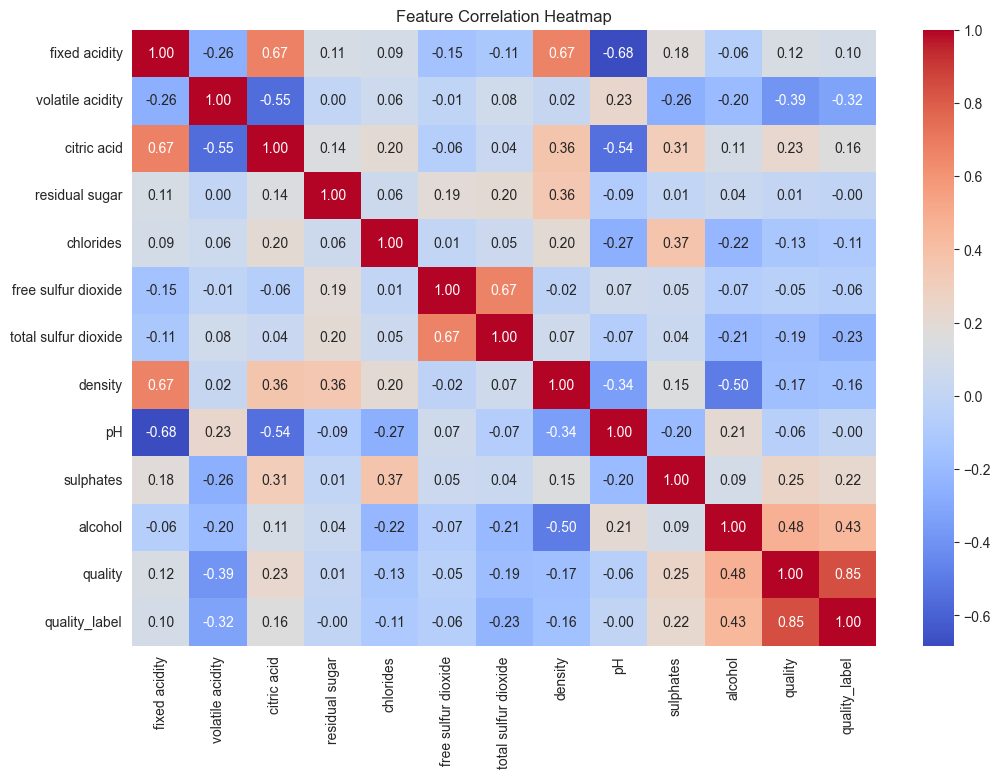

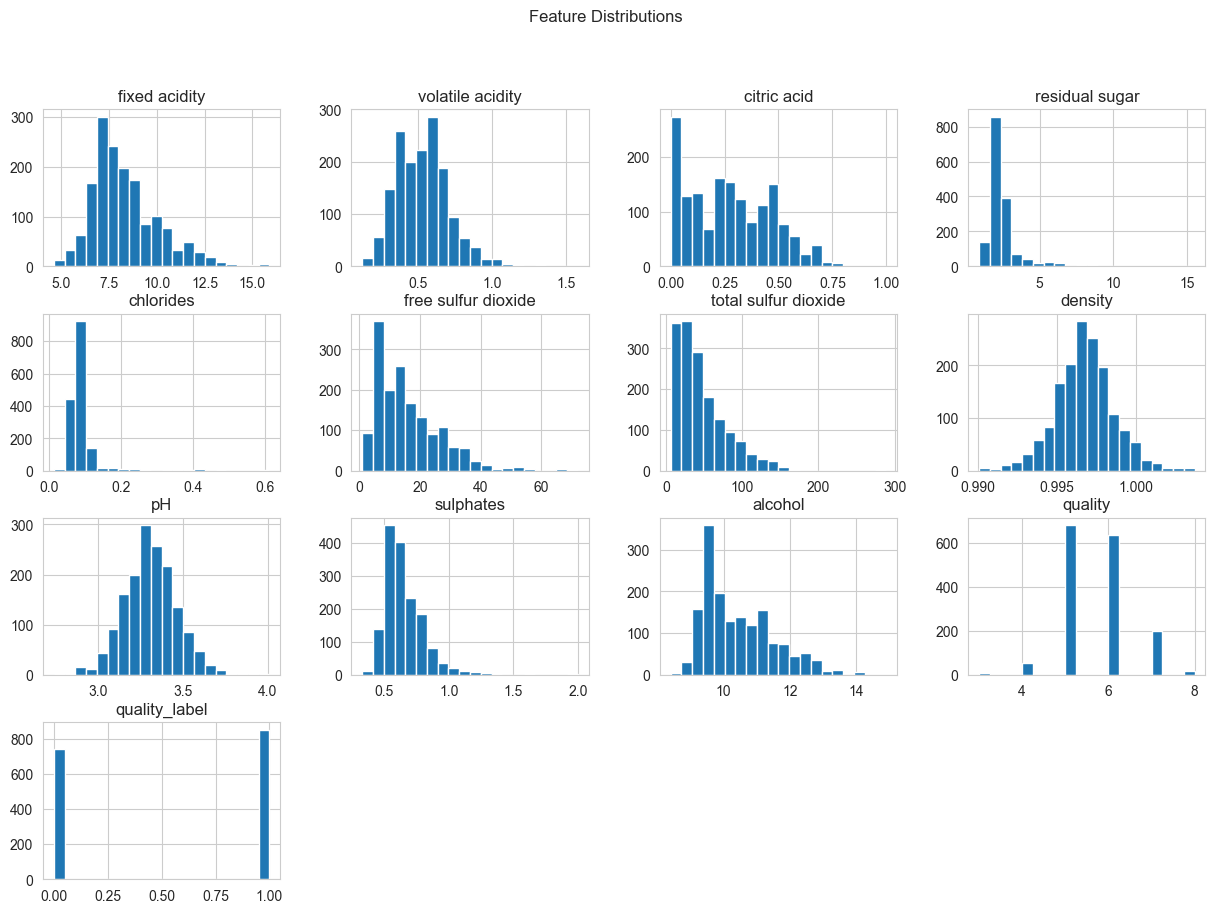

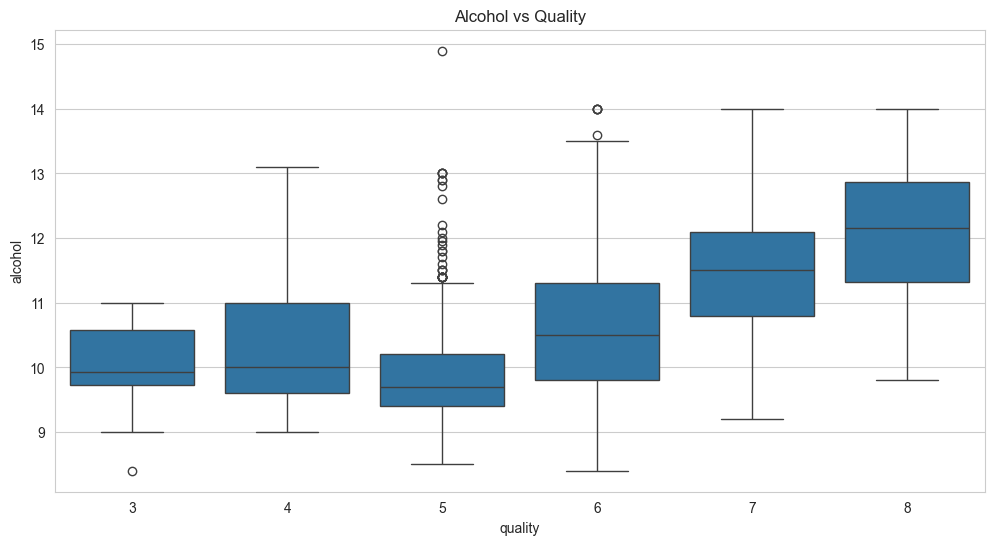

In [3]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_wine.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
print()

# Histogram
df_wine.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()
print()

# Boxplot for key features vs quality
plt.figure(figsize=(12, 6))
sns.boxplot(x='quality', y='alcohol', data=df_wine)
plt.title("Alcohol vs Quality")
plt.show()

In [4]:

# Features and target
X = df_wine.drop(['quality', 'quality_label'], axis=1)
y = df_wine['quality_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#### Modeling

Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       149
           1       0.78      0.75      0.76       171

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



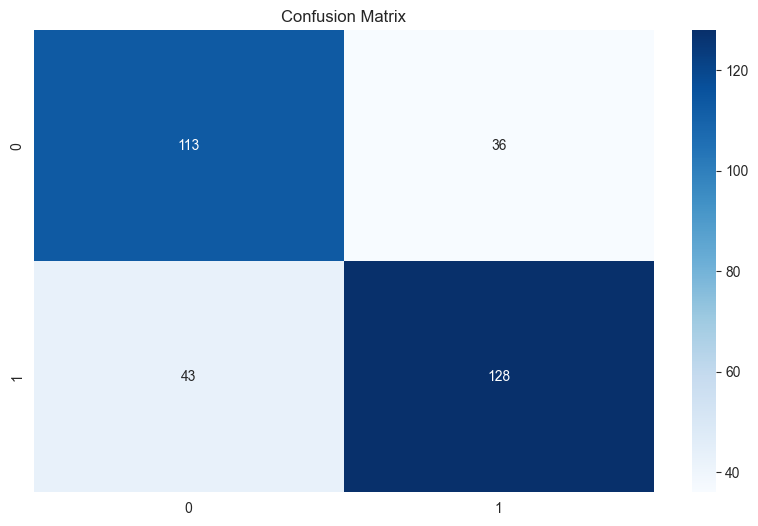

Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       149
           1       0.83      0.80      0.81       171

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



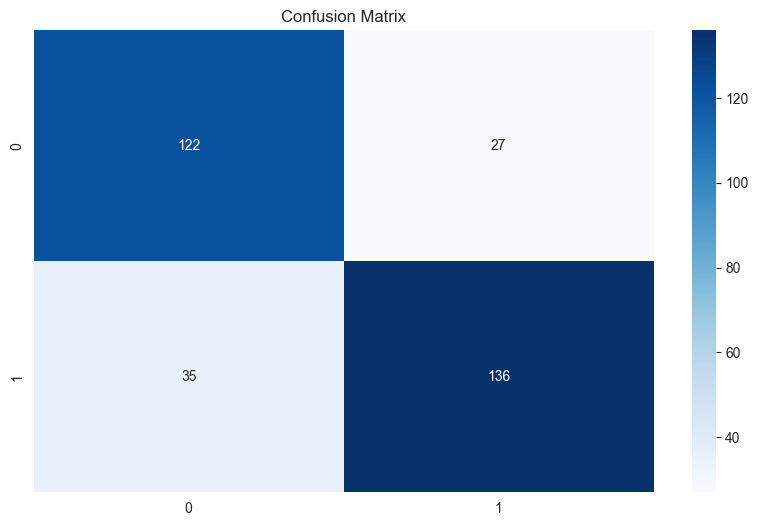

SVM:
              precision    recall  f1-score   support

           0       0.71      0.40      0.52       149
           1       0.62      0.86      0.72       171

    accuracy                           0.65       320
   macro avg       0.67      0.63      0.62       320
weighted avg       0.67      0.65      0.63       320



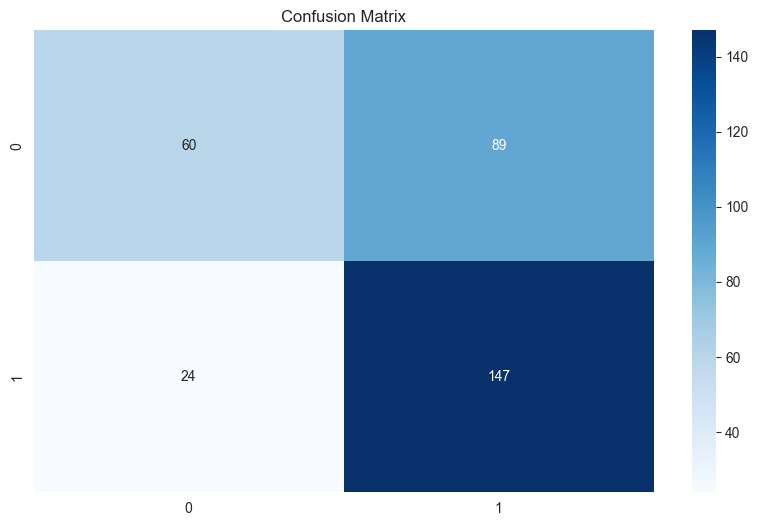

In [5]:
# Helper function for model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Initialize the Logistic Regression model with a maximum of 1000 iterations for optimization
log_reg.fit(X_train, y_train)  # Train the model using the training data (X_train) and target labels (y_train)
print("Logistic Regression:")  # Print the text "Logistic Regression:" to indicate the model being evaluated
evaluate_model(log_reg, X_test, y_test)  # Evaluate the trained Logistic Regression model on the test data (X_test) and true labels (y_test)


# Random Forest Model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
print("Random Forest:")
evaluate_model(rf_clf, X_test, y_test)

# SVM - Support Vector Machine
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
print("SVM:")
evaluate_model(svm_clf, X_test, y_test)


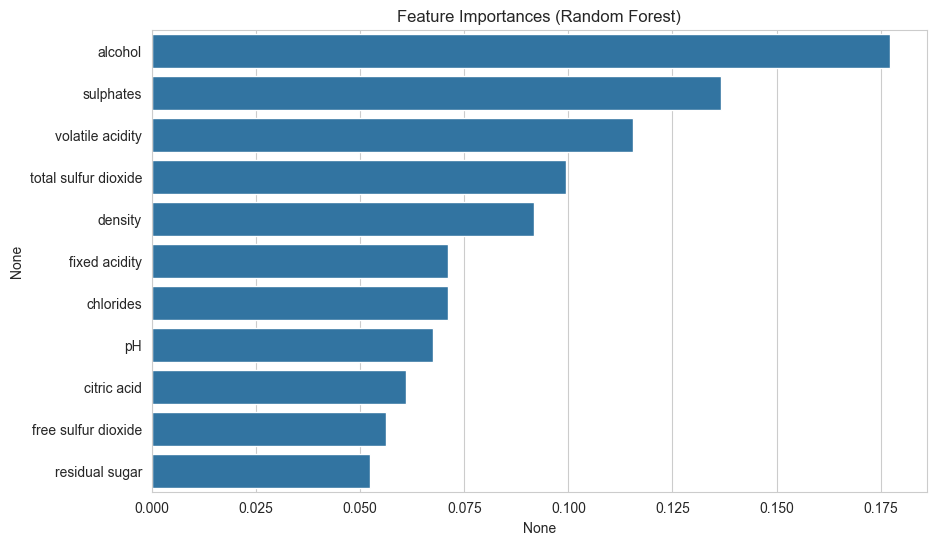

In [6]:
# Score Features
importances = rf_clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Chart importances from Random Forest Model
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importances (Random Forest)")
plt.show()


#### Model Tuning

In [7]:
#Scaling - Not required for Random Forrest but keeping for consistency 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 


# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on training data (assumes scaled)
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print()

# Evaluate on test set
y_pred_best = best_rf.predict(X_test_scaled)
print("Classification Report for Tuned Random Forest:")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       149
           1       0.83      0.81      0.82       171

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



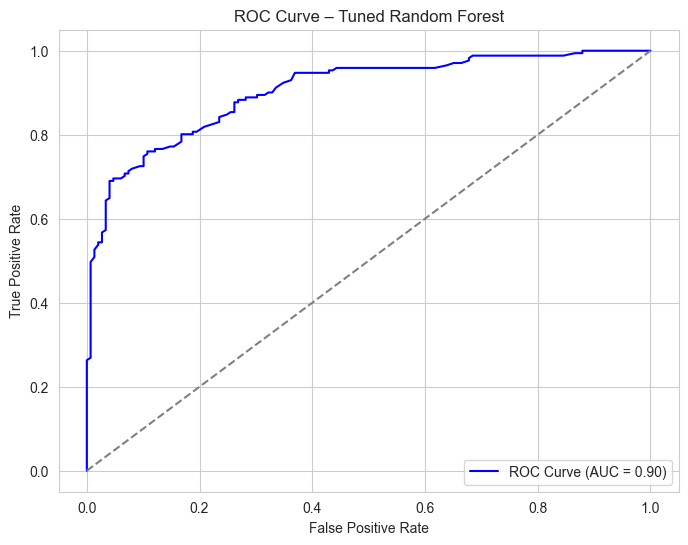

In [8]:
# Predict probabilities for positive class
y_probs = best_rf.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### XGBoost model

Classification Report (XGBoost): 
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       149
           1       0.85      0.82      0.83       171

    accuracy                           0.82       320
   macro avg       0.82      0.83      0.82       320
weighted avg       0.83      0.82      0.83       320



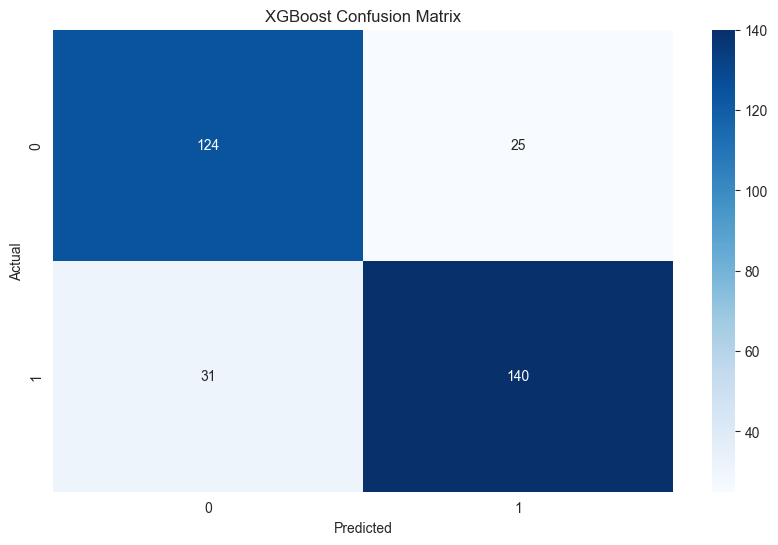

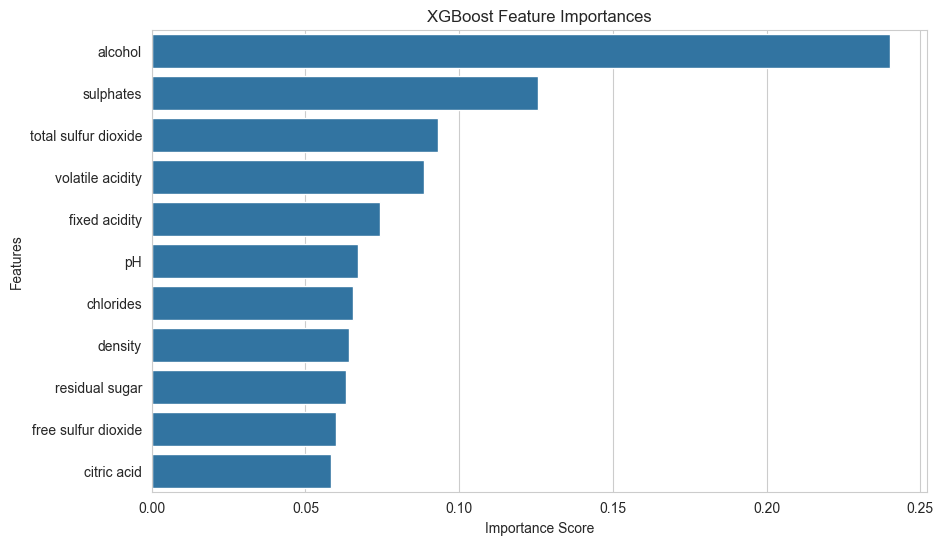

In [9]:
# 1. Initialize and train XGBoost model
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 2. Evaluate model
y_pred = xgb_model.predict(X_test)
print("Classification Report (XGBoost): \n", classification_report(y_test, y_pred))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Feature Importance
importances = xgb_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 5. Graphic
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()